In [1]:
import importlib
import sys,os,math,time

gostNetsFolder = os.path.dirname(os.getcwd())
sys.path.insert(0, gostNetsFolder)
from GOSTNets import GOSTnet as gn
importlib.reload(gn)

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio

from shapely.geometry import Point

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 
peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 


In [22]:
pth = os.path.join(gostNetsFolder, "SampleData")
boundfile = r'AOI.shp'
tif = r'SampleFlood.tif'
tif_path = os.path.join(pth, tif)
points1 = os.path.join(pth, "origins.shp")
points2 = os.path.join(pth, "destinations.shp")

### Generate shape from shapefile

In [32]:
shp = gpd.read_file(os.path.join(pth, boundfile))
bound = shp.geometry.iloc[0]

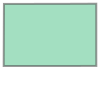

In [33]:
bound

### Get OSM Graph of Road Network

In [34]:
G = ox.graph_from_polygon(bound, network_type = 'drive')

Have a look at what an edge looks like

In [35]:
gn.example_edge(G, 1)

(6010044417, 6013485258, {'osmid': [637515176, 637969614], 'length': 227.43599999999998, 'highway': 'unclassified', 'oneway': False, 'geometry': <shapely.geometry.linestring.LineString object at 0x000002268D5FADA0>})


In [36]:
print('number of roads in object: %d' % G.number_of_edges())
print('number of nodes in object: %d' % G.number_of_nodes())

number of roads in object: 60911
number of nodes in object: 24819


### Convert Network to Time

In [37]:
speed_dict = {
                'residential': 20,  # kmph
                'primary': 40, # kmph
                'primary_link':35,
                'motorway':45,
                'motorway_link': 40,
                'trunk': 40,
                'trunk_link':35,
                'secondary': 30, # kmph
                'secondary_link':25,
                'tertiary':30,
                'tertiary_link': 25,
                'unclassified':20, 
                'road':20,
                'crossing':20,
                'living_street':20
                }

In [38]:
G = gn.convert_network_to_time(G, distance_tag = 'length', speed_dict = speed_dict)

In [39]:
gn.example_edge(G, 1)

(6010044417, 6013485258, {'mode': 'drive', 'time': 40.93848, 'osmid': [637515176, 637969614], 'length': 227.43599999999998, 'highway': 'unclassified', 'oneway': False, 'geometry': <shapely.geometry.linestring.LineString object at 0x000002268D5FADA0>})


### Create association between points and road network nodes

Prepare the point dataframe - make a GeoDataFrame, set crs to WGS84

In [40]:
'''
pointdf = pd.read_csv(points1)
pointdf['geometry'] = list((zip(pointdf.lon, pointdf.lat)))
pointdf['geometry'] = pointdf['geometry'].apply(lambda x: Point(x))
pointgdf = gpd.GeoDataFrame(pointdf, crs = {'init':'espg:4326'}, geometry = 'geometry')
'''
pointgdf = gpd.read_file(points1)

Find the nearest node to each input point. These may not be unique (two or more firms might be mapped to same node)

In [41]:
point_df_with_nearest_node_field = gn.snap_points_to_graph(G, pointgdf)
point_df_with_nearest_node_field

,id,geometry,Nearest_node_ID,Nearest_node_dist
0,1,POINT (36.75688844367101 -1.393906824204006),1158147075,75.682655
1,2,POINT (36.81392789914727 -1.326785558480865),1849993171,146.006898
2,3,POINT (36.88047393053623 -1.335101568222466),281117486,164.909896
3,4,POINT (36.91374694623072 -1.24956415610855),5031056577,44.847221
4,5,POINT (36.78837897638186 -1.232931552114229),272715829,115.357176
5,7,POINT (36.81565775827907 -1.087170539080487),2105894603,1089.515030


In [42]:
list_of_nearest_nodes = list(point_df_with_nearest_node_field.Nearest_node_ID)
unique_list_of_nearest_nodes = list(set(list_of_nearest_nodes))

### Map flooding onto nodes

In [56]:
importlib.reload(gn)
G = gn.sample_raster(G, tif_path, property_name = 'flood_depth')

peartree version: 0.6.0 
networkx version: 2.2 
matplotlib version: 2.2.2 
osmnx version: 0.8.2 
24819
1386
23433


In [58]:
gn.example_node(G, 1)

(6010044417, {'flood_depth': 0.0, 'x': 36.8861095, 'osmid': 6010044417, 'y': -1.2527366})


Make a geodataframe of the nodes, check to see info has bonded on correctly

In [16]:
G_node_gdf = gn.node_gdf_from_graph(G)
print('total number of nodes: %d' % len(G_node_gdf))

total number of nodes: 20044


In [17]:
print('number of nodes where flood depth positive: %d' % len(G_node_gdf.loc[G_node_gdf.flood_depth > 0]))

number of nodes where flood depth positive: 426


### Calculate baseline OD-matrix with no disruption to nodes

In [18]:
test = 1
if test == 1:
    origins = [579895905, 579895194, 1691717692, 2295631025, 579895558, 292841812, 1685661577]
    destinations = [475034453, 475033971, 1461132301, 475032795, 576558929, 579993265, 579993257]
else:
    origins = unique_list_of_nearest_nodes
    destinations = unique_list_of_nearest_nodes

fail_value = 999999999999999

baseline_OD = gn.calculate_OD(G, origins, destinations, fail_value)

Throw this into a dataframe and send to .csv for future reference

In [19]:
OD_df = pd.DataFrame(baseline_OD)
OD_df.to_csv(os.path.join(pth, 'baseline_OD.csv'))

### Knock out part of the network due to a flood

methodological note: instead of actually removing a link, what this does is set the time taken to cross the link to an enormously high value (the fail value). It's a surprise tool that will help us later when summarising the OD

In [20]:
my_flood_depth = 0.1

In [36]:
import GOSTnet as gn

G_flood = gn.disrupt_network(G, 'flood_depth', my_flood_depth, fail_value)

### Return new OD matrix

In [39]:
flooded_OD = gn.calculate_OD(G_flood, origins, destinations, fail_value)

In [40]:
flood_OD_df = pd.DataFrame(flooded_OD)
flood_OD_df.to_csv(os.path.join(pth, 'flooded_OD.csv'))

### Count all of the disrupted trips

In [41]:
masked_OD = np.ma.masked_greater(flooded_OD, value = (fail_value - 1))

impossible_trips = masked_OD.mask.sum()
print(impossible_trips)

14


In [42]:
OD_df

,0,1,2,3,4,5,6
0,278.509560,224.309640,372.422400,383.015657,555.466877,330.391680,469.380900
1,101.351280,47.151360,195.264120,257.181539,401.219760,153.233400,292.222620
2,282.360366,337.607166,514.211286,134.915207,307.366427,472.180566,611.169786
3,453.338700,399.138780,547.251540,322.383407,494.834627,505.220820,644.210040
4,326.704140,272.504220,420.616980,482.534399,626.572620,378.586260,517.575480
5,310.369896,365.616696,542.220816,162.924737,335.375957,500.190096,639.179316
6,328.723080,274.523160,422.635920,220.821497,393.272717,380.605200,519.594420


In [43]:
flood_OD_df

,0,1,2,3,4,5,6
0,5.392647e+02,6.155182e+02,7.996507e+02,3.836538e+02,5.561050e+02,7.546669e+02,9.488542e+02
1,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15,1.000000e+15
2,2.000000e+15,2.000000e+15,2.000000e+15,2.000000e+15,2.000000e+15,2.000000e+15,2.000000e+15
3,4.779943e+02,5.542478e+02,7.383803e+02,3.223834e+02,4.948346e+02,6.933965e+02,8.875838e+02
4,8.137560e+02,8.900095e+02,1.074142e+03,6.581451e+02,8.305963e+02,1.029158e+03,1.223345e+03
5,6.483790e+02,7.246325e+02,9.087650e+02,4.927681e+02,6.652193e+02,8.637812e+02,1.057968e+03
6,4.240679e+02,5.003214e+02,6.844538e+02,2.684570e+02,4.409082e+02,6.394701e+02,8.336573e+02


In [27]:
flood_gdf_edge = gn.edge_gdf_from_graph(G_flood)
flood_gdf_edge.to_csv(os.path.join(pth, 'flood_edge.csv'))
flood_gdf_node = gn.node_gdf_from_graph(G_flood)
flood_gdf_node.to_csv(os.path.join(pth, 'flood_node.csv'))